# Final Code

# 1. import library

In [2]:
import numpy as np
import pandas as pd
import sys
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns
sns.set()

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,learning_curve, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold

In [4]:
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

In [5]:
import xgboost as xgb
from xgboost import XGBClassifier
import catboost as catb
from catboost import CatBoostClassifier
import lightgbm
from lightgbm import LGBMClassifier

In [27]:
from joblib import dump, load
from sklearn.ensemble import VotingClassifier

In [6]:
print("lightgbm",lightgbm.__version__)
print('sklearn',sklearn.__version__)
print('pandas',pd.__version__)
print('numpy',np.__version__)
print('python',sys.version)

lightgbm 2.3.1
sklearn 0.21.3
pandas 0.25.1
numpy 1.16.5
python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


# 2. read & preprocess data

In [7]:
train = pd.read_csv("data/dacon_galaxy/train.csv", index_col=0)
test = pd.read_csv('data/dacon_galaxy/test.csv', index_col=0)
sample_submission = pd.read_csv('data/dacon_galaxy/sample_submission.csv', index_col=0)

In [8]:
# 대회에서 제공한 기본 전처리 과정
# https://dacon.io/competitions/official/235573/codeshare/628
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))

In [9]:
train.head()

,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,...,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,type_num
id,,,,,,,,,,,,,,,,,,,,,
0,QSO,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,...,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340,8
1,QSO,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,...,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314,8
2,QSO,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,...,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928,8
3,QSO,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,...,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855,8
4,STAR_RED_DWARF,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,...,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655,10


# 3. EDA

### EDA : train set 

In [10]:
# 결측치 확인(NaN)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199991 entries, 0 to 199990
Data columns (total 23 columns):
type          199991 non-null object
fiberID       199991 non-null int64
psfMag_u      199991 non-null float64
psfMag_g      199991 non-null float64
psfMag_r      199991 non-null float64
psfMag_i      199991 non-null float64
psfMag_z      199991 non-null float64
fiberMag_u    199991 non-null float64
fiberMag_g    199991 non-null float64
fiberMag_r    199991 non-null float64
fiberMag_i    199991 non-null float64
fiberMag_z    199991 non-null float64
petroMag_u    199991 non-null float64
petroMag_g    199991 non-null float64
petroMag_r    199991 non-null float64
petroMag_i    199991 non-null float64
petroMag_z    199991 non-null float64
modelMag_u    199991 non-null float64
modelMag_g    199991 non-null float64
modelMag_r    199991 non-null float64
modelMag_i    199991 non-null float64
modelMag_z    199991 non-null float64
type_num      199991 non-null int64
dtypes: float64(20),

In [11]:
# EDA를 위한 plot size 지정
fig = plt.figure()
plt.rcParams["figure.figsize"] = (15,5)

<Figure size 432x288 with 0 Axes>

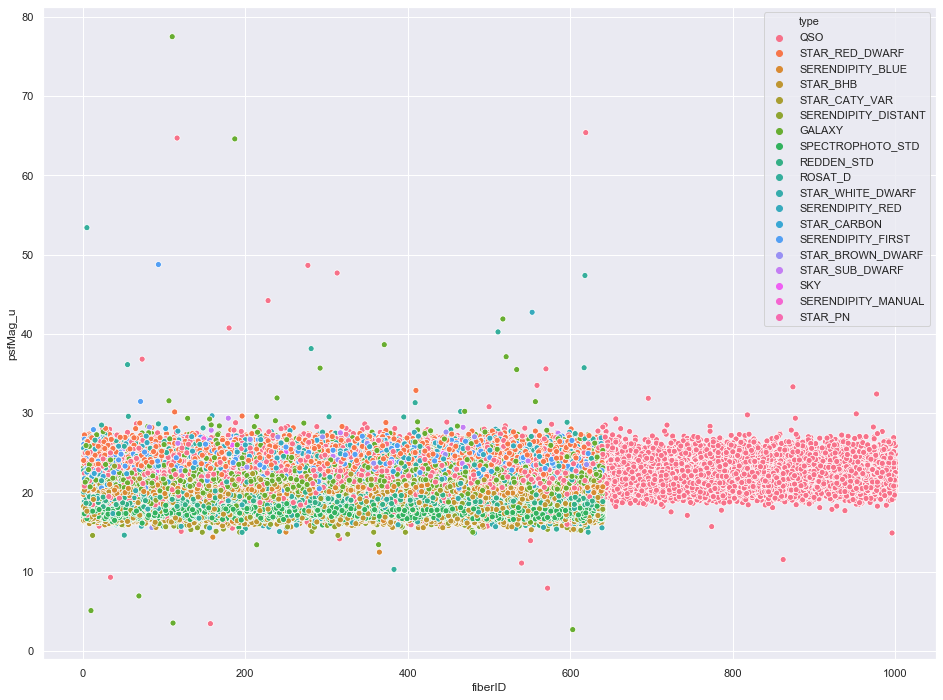

In [24]:
fig = plt.figure(figsize=(16, 12))
train_tmp = train.copy()
# filter selection -> Boolean Indexing 
# train set에 극단치들이 존재하기에 특정 범위에 대해서 조사
train_tmp = train_tmp[(train_tmp["psfMag_u"]>0) & (train_tmp["psfMag_u"]<100)]

sns.scatterplot(x="fiberID", 
                y="psfMag_u", 
                hue="type",
                data=train_tmp)

- fiberID가 641 이상일 때는 QSO type에 대해서만 측정

<BarContainer object of 19 artists>

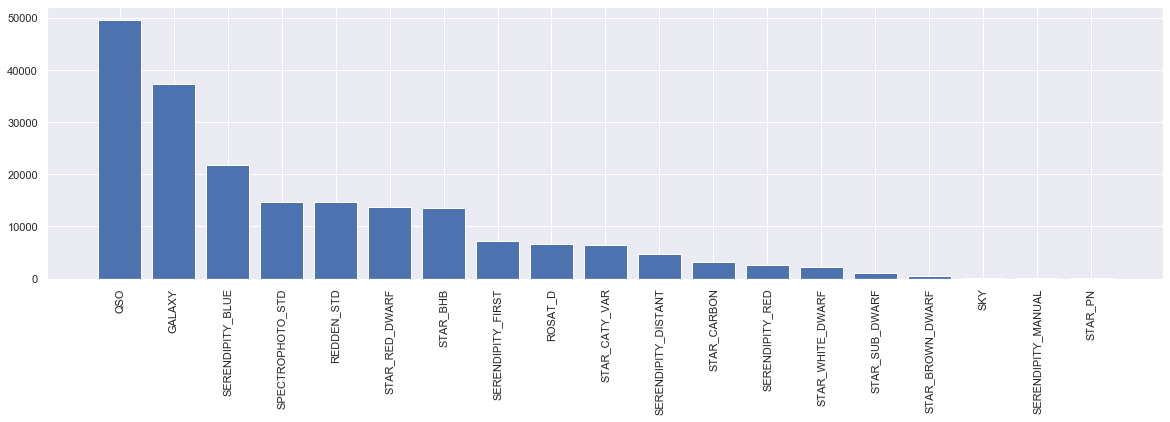

In [32]:
# type별 데이터 분포도
# type별로 데이터 분포가 차이 존재
value_dist = train['type'].value_counts()

fig = plt.figure(figsize=(20, 5))
ax = plt.subplot(1, 1, 1)

for label in ax.xaxis.get_ticklabels() :
    label.set_rotation(90)

ax.bar(value_dist.index, value_dist.values)

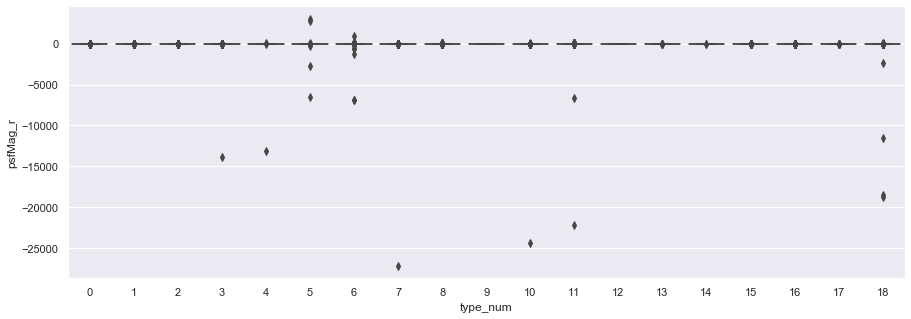

In [53]:
# outlier 조사
sns.boxplot('type_num', 'psfMag_r', data=train)

상당히 동떨어진 outlier가 존재

### EDA : test set 

In [12]:
# test set에 대한 결측치 조사
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10009 entries, 199991 to 209999
Data columns (total 21 columns):
fiberID       10009 non-null int64
psfMag_u      10009 non-null float64
psfMag_g      10009 non-null float64
psfMag_r      10009 non-null float64
psfMag_i      10009 non-null float64
psfMag_z      10009 non-null float64
fiberMag_u    10009 non-null float64
fiberMag_g    10009 non-null float64
fiberMag_r    10009 non-null float64
fiberMag_i    10009 non-null float64
fiberMag_z    10009 non-null float64
petroMag_u    10009 non-null float64
petroMag_g    10009 non-null float64
petroMag_r    10009 non-null float64
petroMag_i    10009 non-null float64
petroMag_z    10009 non-null float64
modelMag_u    10009 non-null float64
modelMag_g    10009 non-null float64
modelMag_r    10009 non-null float64
modelMag_i    10009 non-null float64
modelMag_z    10009 non-null float64
dtypes: float64(20), int64(1)
memory usage: 1.7 MB


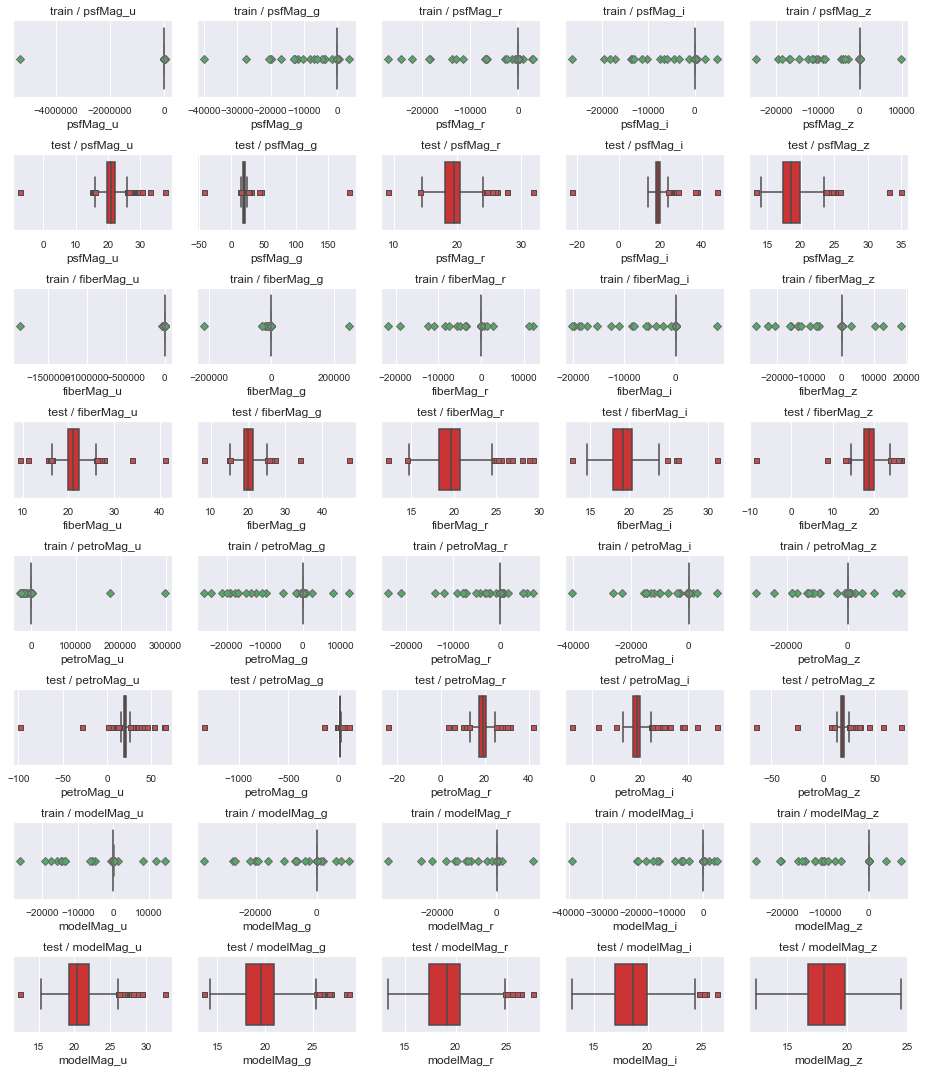

In [18]:
# train과 test feature별 데이터 분포 비교
# 녹색: train / 적색: test

fig, ax = plt.subplots(8,5, figsize=(13,15))
green_diamond = dict(markerfacecolor='g', marker='D')
red_square = dict(markerfacecolor='r', marker='s')
for idx, column in enumerate(train.columns[2:-1]):
    row = 2*int(idx/5)
    col = idx%5
    sns.boxplot(train[column], ax=ax[row, col], flierprops=green_diamond, palette="Set3")
    sns.boxplot(test[column], ax=ax[row+1, col], flierprops=red_square,  palette="Set1")
    ax[row, col].set_title('train / ' + column)
    ax[row+1, col].set_title('test / ' + column)
    ax[row, col].tick_params(labelsize=10)
    ax[row+1, col].tick_params(labelsize=10)
    
fig.tight_layout()

# 4. Data Handling & Feature Engineering

In [25]:
# 1) train set과 test set에서 fiberID >= 641인 데이터에 대해서 QSO로 예측하도록 칼럼 추가
train['isQSO'] = train['fiberID'].apply(lambda x: 1 if x >= 641 else 0)
test['isQSO'] = test['fiberID'].apply(lambda x: 1 if x >= 641 else 0)

In [137]:
# 2) test fiberID >= 641인 데이터에 대해서 train set 이어서 붙이기
test_concat = test[test['fiberID'] >= 641]
test_concat.loc[:,'type'] = "QSO"
train_test = pd.concat([train, test_concat])

# train & test 합친 data set의 칼럼 다시 지정
train_test = train_test[train.columns]

- 1), 2) 방법으로 data handling 후 모델을 돌려본 결과 성능이 오히려 떨어짐
- 이에 대한 부분은 생략하기로 결정

### outlier 제거

In [20]:
# outlier 제거
# test set의 분포를 기준으로 train set의 outlier를 제거

for column in train.columns[2:-1]:
    test_min_value = test[column].min()
    test_max_value = test[column].max()

    for column in train.columns[2:-1]:
        # test set 분포 범위 극단값에서 ±100 지정 -> test범위 보다 train set의 범위가 더 작아지는 것을 방지
        train = train.drop(index=train[(train[column] <= test_min_value-100) | (train[column] >= test_max_value+100)].index)

    train = train.reset_index(drop=True)
    
train.shape

(199880, 23)

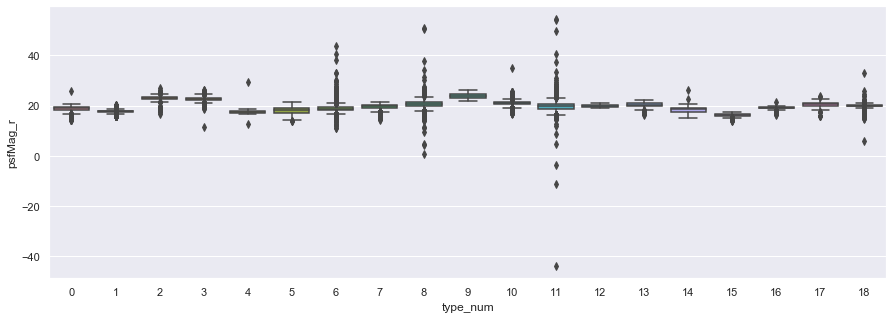

In [21]:
# outlier 제거 후 (하나의 칼럼에 대해서만 도표화)
sns.boxplot('type_num', 'psfMag_r', data=train)

In [21]:
# value_counts()의 결과를 토대로 데이터 개수가 가장 큰 QSO를 기준으로 한다.
# 1. n: QSO의 데이터개수를 각 type의 데이터개수로 나눈 몫
# 2. 각 type의 전체데이터를 (n-1)번 만큼 복사해서 append해준다.
# 3. r: QSO의 데이터개수를 각 type의 데이터개수로 나눈 나머지
# 4. 2번 과정을 거친 후 QSO와 차이나는 남는 데이터개수를 random sample을 통해 뽑아서 추가해준다.

def equalTypeNumber(df):
    dist_value = df['type'].value_counts()
    type_list = dist_value.index
    for idx, typeName in enumerate(type_list):
        if idx == 0:
            continue
        
        # 3번 과정: 나머지에 해당하는 부분을 미리 뽑아서 sample_train으로 다시 dataframe 만들기 
        # 이 과정을 1번보다 먼저해야 한다.
        count = dist_value.values[0] % dist_value.values[idx]
        random_idx = random.sample(list(np.arange(0,len(df[df['type'] == typeName]),1)), count)
        sample_train = df.iloc[df[df['type'] == typeName].index[random_idx]]
        
        # 1번 과정: 나눈 몫을 미리 구함
        duplicate = int(dist_value.values[0] / dist_value.values[idx])
        temp = df[df['type'] == typeName]
        
        # 2번 과정: (n-1)만큼 복사해서 append해주는 과정
        for i in range(duplicate - 1):
            tmp_idx1 = {original_idx : (new_idx + len(df)) for new_idx, original_idx in enumerate(temp.index)}
            temp.rename(index=tmp_idx1, inplace=True)
            df = df.append(temp)
        
        # 4번 과정: 미리 뽑아놓은 나머지에 대한 부분을 붙이는 과정
        tmp_idx2 = {original_idx : (new_idx + len(df)) for new_idx, original_idx in enumerate(sample_train.index)}
        sample_train.rename(index=tmp_idx2, inplace=True)
        df = df.append(sample_train)
        
    return df

train = equalTypeNumber(train)
train

# 이렇게하면 overfitting 발생

- train을 value_counts 하면 위의 도표에서 제시한 대로 type별 데이터 개수의 차이가 존재
- 데이터 개수가 가장 많은 QSO type을 기준으로 다른 type의 데이터 개수를 인위적으로 늘리는 과정
- **이런 방식으로 data handling해서 모델을 돌려본 결과 overfitting 결과를 초래함**

# 5. Modeling Preparation

In [22]:
# train set 정답지, 문제지 / test set 설정
train_X = train.drop(columns=['type', 'type_num'], axis=1)
train_y = train['type_num']
test_x = test

In [23]:
print(train_X.shape) # train의 문제지
print(train_y.shape) # train의 정답지
print(test_x.shape) # test: 풀어야할 문제지

(199880, 21)
(199880,)
(10009, 21)


In [45]:
# validation을 위한 train_test_split 진행
# 데이터 개수 동일화 작업을 skip하고 본래 데이터를 대상으로 하는 경우 stratify parameter를 입력해야 한다.
X_train, X_test, y_train, y_test = train_test_split(train_X, 
                                                    train_y, 
                                                    stratify = train_y,
                                                    test_size=0.2, 
                                                    random_state=1234)

In [14]:
# StratifiedKFold or KFold 사용 (train 데이터 정답지의 개수 분포를 보고 결정)

# kfold = KFold(n_splits=6, random_state= 0, shuffle = True)
kfold_s = StratifiedKFold(n_splits=7, random_state= 0, shuffle = True)

# 6. Model Training

## XGBoost, LightGBM, CatBoost 각각에 대해 parameter tuning

In [ ]:
# LGBM parameter tuning
# Bayesian optimization 적용

LGB = LGBMClassifier(random_state =1234, 
                     n_jobs = -1,
                     devices='gpu')

lb_param_grid = {
    'learning_rate' : np.arange(0.1,0.15,0.01),
    'num_iterations' : [200],
    'max_bin' : [300],
    'num_leaves':[90],
    'max_depth' : [6,7,8],
    'min_child_weight': [0.1],
    'min_split_gain':[0.3]
    'device_type'=['gpu']
    'num_boost_round' : [1000]
}

In [26]:
# CatBoost parameter tuning
CBC = CatBoostClassifier(random_state=1234, task_type="GPU", devices='0:1')

cbc_param_grid = {
#    'n_estimators' : [10, 30, 50],
#    'max_depth' : np.arange(3,10,1),
   'learning_rate' : [0.1599, 0.165, 0.17], #np.arange(0.159,0.18,0.01),
   'iterations' : [1000],
   'depth' : [8],
   'loss_function' : ['MultiClass'], #Logloss
   'leaf_estimation_method' : ['Newton'],
   'eval_metric' : ['Accuracy'] #AUC
}

In [62]:
#XGBoost parameter tuning
XGBC = XGBClassifier(tree_method='gpu_hist', gpu_id=0, random_state=1234)

xgc_param_grid = {
    'n_estimators':[200] ,
    'learning_rate' : [0.1],
    'eta': np.arange(0.1,0.3,0.1),
    #'min_child_weight' : np.arange(4,7,1),
    'max_depth': [8,9]             
}

In [27]:
n_iter_search = 10
CBC_rgs = RandomizedSearchCV(CBC, 
                             cbc_param_grid, 
                             cv=kfold_s,
                             # gpu 사용시 충돌 발생 가능
                             # n_jobs=-1,
                             scoring='neg_log_loss',
                             random_state=1234)

In [ ]:
def RandomizedSearchByAnyModel(model, param):
    model_rs = RandomizedSearchCV(model,
                                 param,
                                 cv=kfold_s,
                                 n_jobs=-1,
                                 scoring='neg_log_loss',
                                 random_state=1234)
    
    # validation 스킵할 경우 본래 데이터 가지고 학습 진행
    model_rs.fit(train_X, train_y)
    
    return model_rs

In [ ]:
result_model = RandomizedSearchByAnyModel(LGB, lb_param_grid)

In [33]:
# RandomizedSearch를 통해 나온 model에서 가장 best한 score 확인
result_model.best_score_

-0.3734726325801781

In [ ]:
# RandomizedSearch 통해 나온 model의 가장 최적의 모델 확인
result_model.best_estimator_

In [ ]:
# 학습시킨 각각의 최적의 모델에 대해 pkl 파일로 저장 
model_best_estimator = result_model.best_estimator_
dump(model_best_estimator, "model_name.pkl")

## 저장해둔 모델 불러오기

In [ ]:
# 저장해두었던 각 model별 여러 개의 pkl 파일 불러오기
# 필요에 따라 여러 개 불러오기 가능
# feature engineering 뿐만 아니라 voting, stacking model 학습에도 이용

xgb_model = load('pkl_file/200224_xgb_feature_weighting.pkl')
lgbm_model = load('pkl_file/200224_lgb2.pkl')

catb_model2 = load('pkl_file/200225_Cat_0.36944.pkl')
xgb_model2 = load('pkl_file/200222_xgb_feature_weighting.pkl')
lgbm_model2 = load('pkl_file/200225_lgb3.pkl')

catb_model3 = load('pkl_file/200225_Cat_0.3942.pkl')

# voting_model = load('pkl_file/200220_Voting.pkl')

## 학습을 통해 도출한 model의 성능 측정(각 type 별로)

In [46]:
# Validation을 위한 작업
# 이 때는 위에서 모델학습을 할 때 train_test_split을 통해 train set을 분리했던 데이터로 진행해야 함
y_pred = lgbm_best.predict(X_test)

In [49]:
# CatBoost predict 결과가 이중 numpy.array형태로 되어있어서 벗겨서 list로 만드는 작업
y_pred_list = []
for i in y_pred:
    y_pred_list.append(int(i))

- CatBoost 사용시 list로 변환해주어야 한다.
- CatBoost 이외의 알고리즘은 변환해줄 필요 없다.

In [50]:
category = {}
for i, column in enumerate(sample_submission.columns):
    category[i] = column

In [ ]:
xgb_model = load('pkl_file/200224_xgb_feature_weighting.pkl')
lgbm_model = load('pkl_file/200224_lgb2.pkl')

catb_model2 = load('pkl_file/200225_Cat_0.36944.pkl')
xgb_model2 = load('pkl_file/200222_xgb_feature_weighting.pkl')
lgbm_model2 = load('pkl_file/200225_lgb3.pkl')

catb_model3 = load('pkl_file/200225_Cat_0.3942.pkl')

# voting_model = load('pkl_file/200220_Voting.pkl')

In [51]:
# 글자 색상 결정
C_END = "\033[0m"
C_RED = "\033[31m"
C_BOLD = "\033[1m"

# 각 카테고리(type)별로 해당 모델이 얼마나 잘 예측을 했는지 정확도 % 비교
# 예측이 잘된 category와 아닌 category가 발생
for cate in range(19):
    prob = sum(((y_test == cate) & (y_test == y_pred_list))) / sum(y_test == cate)
    if(prob < 0.85):
        print(C_BOLD + C_RED + "category"+ str(cate) +"\t"+ category[cate]+' : ' + str(prob) + C_END)
    else:
        print("category",cate,"\t"+ category[cate],':', prob)

category0	STAR_WHITE_DWARF : 0.6597222222222222
category 1 	STAR_CATY_VAR : 0.9684857801691007
category 2 	STAR_BROWN_DWARF : 0.88
category 3 	SERENDIPITY_RED : 0.94921875
category 4 	REDDEN_STD : 0.9798152582962709
category 5 	STAR_BHB : 0.8999629492404594
category 6 	GALAXY : 0.98900951615065
category7	SERENDIPITY_DISTANT : 0.7089151450053706
category 8 	QSO : 0.9097956307258633
category 9 	SKY : 0.96
category 10 	STAR_RED_DWARF : 0.9894545454545455
category11	ROSAT_D : 0.38443935926773454
category12	STAR_PN : 0.6666666666666666
category13	SERENDIPITY_FIRST : 0.67671809256662
category 14 	STAR_CARBON : 0.9846390168970814
category 15 	SPECTROPHOTO_STD : 0.9702665755297334
category 16 	STAR_SUB_DWARF : 0.9567099567099567
category17	SERENDIPITY_MANUAL : 0.8333333333333334
category 18 	SERENDIPITY_BLUE : 0.9161112387956791


- 위의 각 카테고리별 정확도를 비교한 것은 model마다 예측을 잘한 type과 아닌 type이 다를 것으로 판단
- 이를 기준으로 XGB, LGBM, CatB 모델마다 비교
- 비교를 통해 각각 예측을 잘한 type에 인위적 Voting 때 가중치를 주어서 결과값을 도출하고자 함
- 진행해본 결과로는 큰 성능 개선이 이루어지지는 않았음

## 각 모델마다 feature 중요도 분포를 기준으로 다시 feature engineering 진행

In [16]:
# 각 모델의 feature_importances_ 진행
xgb_feature = xgb_model2.feature_importances_
cat_feature = catb_model3.feature_importances_ / 100
lgbm_feature = lgbm_model2.feature_importances_ / sum(lgbm_model.feature_importances_)

In [20]:
xgb_feature_importance = {}
cat_feature_importance = {}
lgbm_feature_importance = {}

# 각 모델별로 dictionary 생성
# key: 각 feature, value: 그에 해당하는 feature중요도 / 이 형태로 생성
for idx, column in enumerate(train.columns[1:-1]):
    xgb_feature_importance[column] = xgb_feature[idx]
    cat_feature_importance[column] = cat_feature[idx]
    lgbm_feature_importance[column] = lgbm_feature[idx]

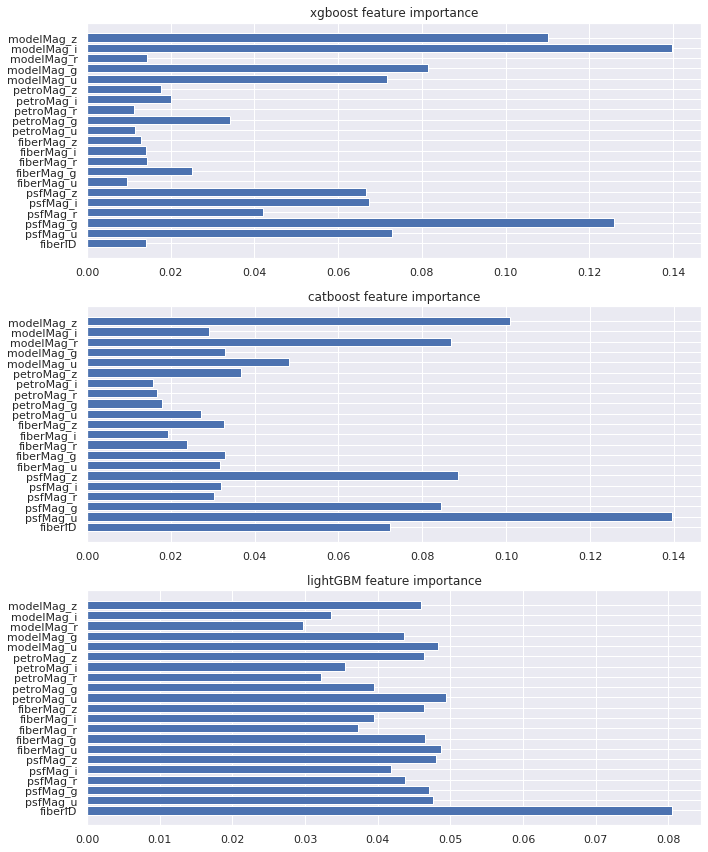

In [21]:
# 시각화 작업

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,12))

ax1.barh(list(xgb_feature_importance.keys()), list(xgb_feature_importance.values()))
ax1.set(title='xgboost feature importance')

ax2.barh(list(cat_feature_importance.keys()), list(cat_feature_importance.values()))
ax2.set(title='catboost feature importance')

ax3.barh(list(lgbm_feature_importance.keys()), list(lgbm_feature_importance.values()))
ax3.set(title='lightGBM feature importance')

fig.tight_layout()
plt.show()

In [24]:
# 위의 feature importance에 따라 각 모델에 따라 가중치를 주어 새로운 feature 생성
# train set feature engineering
train['xgb_weight'] = train[train.columns[2:-1]].apply(lambda x : sum(np.array(x)*xgb_feature[1:-3]), axis=1)
train['cat_weight'] = train[train.columns[2:-2]].apply(lambda x : sum(np.array(x)*cat_feature[1:]), axis=1)
train['light_weight'] = train[train.columns[2:-3]].apply(lambda x : sum(np.array(x)*lgbm_feature[1:-3]), axis=1)

In [25]:
# test set feature engineering
test['xgb_weight'] = test[test.columns[1:]].apply(lambda x : sum(np.array(x)*xgb_feature[1:-3]), axis=1)
test['cat_weight'] = test[test.columns[1:-1]].apply(lambda x : sum(np.array(x)*cat_feature[1:]), axis=1)
test['light_weight'] = test[test.columns[1:-2]].apply(lambda x : sum(np.array(x)*lgbm_feature[1:-3]), axis=1)

- feature engineering 이후에 위로 다시 올라가 5번 Model Preparation 진행
- 5번 수행 후 6번 Model Training 진행해 새로운 최적의 모델 생성

# 7. Voting

In [ ]:
# VotingClassifier를 이용해 여러 최적의 모델들을 재료로 학습
# soft voting을 진행, hard voting보다 성능이 좋게 나옴

eclf = VotingClassifier(estimators=[('xgb',xgb_model),
                                  ('lgbm', lgbm_model), 
                                  ('catb2', catb_model2),
                                  ('xgb2',xgb_model2),
                                  ('lgbm2', lgbm_model2),
                                 ('catb3', catb_model3)], 
                        voting='soft')

eclf.fit(train_X, train_y)

In [23]:
eclf

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=0, learning_rate=0.1,
                                            max_delta_step=0, max_depth=9,
                                            min_child_weight=1, missing=nan,
                                            n_estimators=200, n_jobs=1,
                                            nthread=None,
                                            objective='multi:softprob',
                                            random_state=1234, reg_alpha=0,
                                            reg_lambda=1, scale_...
                                             min_child_weight=0.1,
                                             

In [ ]:
# 필요에 따라 Voting model도 pkl 저장
dump(eclf, "voting_model.pkl")

In [143]:
# Category Weighted Voting
# 여기는 위의 Voting 모델으로 돌리지 않고 직접 코딩을 통해 인위적인 Voting을 진행
# 위에서 진행했던 model별 type정확도를 기준으로 Voting 때 어떠한 모델에 가중치를 줄 것인지 결정하고 진행
# 참고용

total_pred = []
target_list = [0, 7, 11, 12, 13, 17]

for idx in range(len(X_test)):
    temp_list = []
    max_idx = np.argmax(cat_pred[idx])
    # CatB에서 잘 안나온 0, 7, 11, 12, 13, 17 category -> XG에 가중치 up
    # 그 외 나머지는 cat에 가중치
    if max_idx in target_list:
        temp_list = (0.1 * cat_pred[idx] + 0.9 * xgb_pred[idx])
    else:
        temp_list = (0.9 * cat_pred[idx] + 0.1 * xgb_pred[idx])
    
    temp_list = temp_list.tolist()
    total_pred.append(temp_list)
    
total_pred = np.array(total_pred)

- 이 과정 또한 진행해보았으나 큰 성능개선을 이루지 못함
- 이 부분을 잘 수정하면 더 좋은 성과를 기대해도 좋을 것으로 판단

# 8. Submission

In [24]:
# 원하는 model을 대입해 predict_proba를 통해 예측정답지를 생성
y_pred = model.predict_proba(test_x)

In [25]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission_final.csv', index=True)